In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score
import statsmodels.api as sm
from prophet import Prophet
import xgboost as xgb


In [22]:
# Loading dataset
df = pd.read_csv('/content/Bakery sales.csv')

# shape and first few rows of the data
print("Shape of the loaded DataFrame:", df.shape)
print("First few rows of the loaded DataFrame:")
print(df.head())


Shape of the loaded DataFrame: (233999, 6)
First few rows of the loaded DataFrame:
         date   time  ticket_number               article  Quantity unit_price
0  02-01-2021  08:38         150040              BAGUETTE         1      0,90 
1  02-01-2021  08:38         150040      PAIN AU CHOCOLAT         3      1,20 
2  02-01-2021  09:14         150041      PAIN AU CHOCOLAT         2      1,20 
3  02-01-2021  09:14         150041                  PAIN         1      1,15 
4  02-01-2021  09:25         150042  TRADITIONAL BAGUETTE         5      1,20 


In [23]:
# first few rows of the dataset
df.head()

# basic structure and missing data
df.info()

# Summary Stats
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233999 entries, 0 to 233998
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   date           233999 non-null  object
 1   time           233999 non-null  object
 2   ticket_number  233999 non-null  int64 
 3   article        233999 non-null  object
 4   Quantity       233999 non-null  int64 
 5   unit_price     233999 non-null  object
dtypes: int64(2), object(4)
memory usage: 10.7+ MB


,ticket_number,Quantity
count,233999.000000,233999.000000
mean,219202.339048,1.557195
std,40053.027334,1.266838
min,150040.000000,1.000000
25%,184756.000000,1.000000
50%,218808.000000,1.000000
75%,253928.500000,2.000000
max,288913.000000,200.000000


#Data Cleaning and Transformation


In [24]:
# Read the CSV file into a DataFrame
df = pd.read_csv('/content/Bakery sales.csv')

# shape and first few rows of the loaded dataframe
print("Shape of the loaded DataFrame:", df.shape)
print("First few rows of the loaded DataFrame:")
print(df.head())

# 1. Convert 'unit_price' from string (with commas) to float
df['unit_price'] = df['unit_price'].astype(str).str.replace(',', '.').astype(float)

# 2. Convert 'date' to datetime format (DD-MM-YYYY)
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y', errors='coerce')

# 3. Convert 'time' from string (HH:MM) to datetime object and extract time (HH:MM)
df['time'] = pd.to_datetime(df['time'], format='%H:%M', errors='coerce').dt.strftime('%H:%M')

# 4. Extract additional features from 'time' (hour)
df['hour'] = pd.to_datetime(df['time'], format='%H:%M').dt.hour

# 5. Extract 'day_of_week' from 'date' (0 = Monday, 6 = Sunday)
df['day_of_week'] = df['date'].dt.dayofweek

# 6. Extract 'month' from 'date'
df['month'] = df['date'].dt.month

# Check to confirm changes
print("First few rows after cleaning:")
print(df.head())

# Check the data types of columns to confirm the changes
print("\nData types of the cleaned DataFrame:")
print(df.dtypes)


Shape of the loaded DataFrame: (233999, 6)
First few rows of the loaded DataFrame:
         date   time  ticket_number               article  Quantity unit_price
0  02-01-2021  08:38         150040              BAGUETTE         1      0,90 
1  02-01-2021  08:38         150040      PAIN AU CHOCOLAT         3      1,20 
2  02-01-2021  09:14         150041      PAIN AU CHOCOLAT         2      1,20 
3  02-01-2021  09:14         150041                  PAIN         1      1,15 
4  02-01-2021  09:25         150042  TRADITIONAL BAGUETTE         5      1,20 
First few rows after cleaning:
        date   time  ticket_number               article  Quantity  \
0 2021-01-02  08:38         150040              BAGUETTE         1   
1 2021-01-02  08:38         150040      PAIN AU CHOCOLAT         3   
2 2021-01-02  09:14         150041      PAIN AU CHOCOLAT         2   
3 2021-01-02  09:14         150041                  PAIN         1   
4 2021-01-02  09:25         150042  TRADITIONAL BAGUETTE      

In [25]:
# Check for missing values in the DataFrame
missing_values = df.isnull().sum()

# Print the missing values
print("Missing values in each column:")
print(missing_values)


Missing values in each column:
date             0
time             0
ticket_number    0
article          0
Quantity         0
unit_price       0
hour             0
day_of_week      0
month            0
dtype: int64


#Data Aggeregation

In [26]:
# Creating 'total_price' column for each line item
df['total_price'] = df['Quantity'] * df['unit_price']

# Grouping data by 'ticket_number' to find total value and total items per transaction
transaction_summary = df.groupby('ticket_number').agg(
    total_items=('Quantity', 'sum'),
    total_value=('total_price', 'sum')
).reset_index()

# First few rows of the transaction summary
print(transaction_summary.head())


   ticket_number  total_items  total_value
0         150040            4         4.50
1         150041            3         3.55
2         150042            5         6.00
3         150043            5         5.10
4         150044            1         1.05


Exploratory Data Analysis

In [27]:
# most popular items
popular_items = df.groupby('article')['Quantity'].sum().sort_values(ascending=False).head(10)
print("Top 10 most popular items:")
print(popular_items)

# total sales by day of the week
sales_by_day = df.groupby('day_of_week')['total_price'].sum()
print("Sales by day of the week:")
print(sales_by_day)

# sales by month
sales_by_month = df.groupby('month')['total_price'].sum()
print("Sales by month:")
print(sales_by_month)


Top 10 most popular items:
article
TRADITIONAL BAGUETTE    118723
CROISSANT                29990
PAIN AU CHOCOLAT         25498
COUPE                    23697
BANETTE                  23008
BAGUETTE                 22259
CEREAL BAGUETTE           7529
SPECIAL BREAD             5520
FORMULE SANDWICH          5389
TARTELETTE                5082
Name: Quantity, dtype: int64
Sales by day of the week:
day_of_week
0     71141.55
1     64950.15
2     47816.20
3     67040.20
4     73637.60
5     90703.95
6    122513.25
Name: total_price, dtype: float64
Sales by month:
month
1     30061.25
2     33512.35
3     38545.60
4     48347.45
5     57424.95
6     48987.00
7     84544.50
8     97589.55
9     41815.95
10    21776.15
11    17301.25
12    17896.90
Name: total_price, dtype: float64


# Visualization

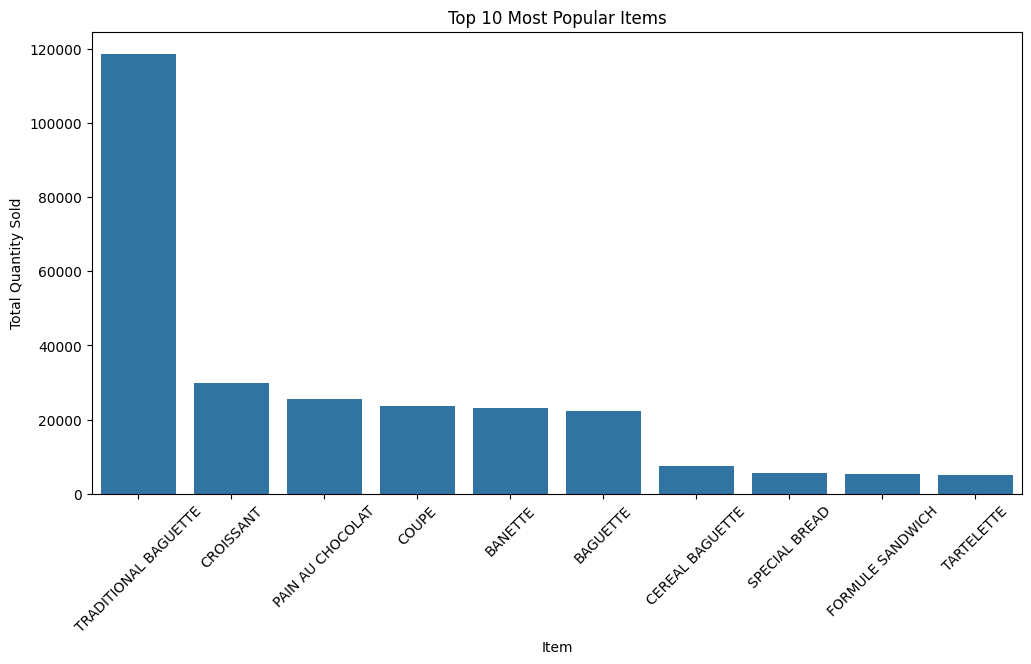

In [29]:
# Plotting top 10 most popular items
plt.figure(figsize=(12, 6))
sns.barplot(x=popular_items.index, y=popular_items.values)
plt.title('Top 10 Most Popular Items')
plt.xlabel('Item')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.show()

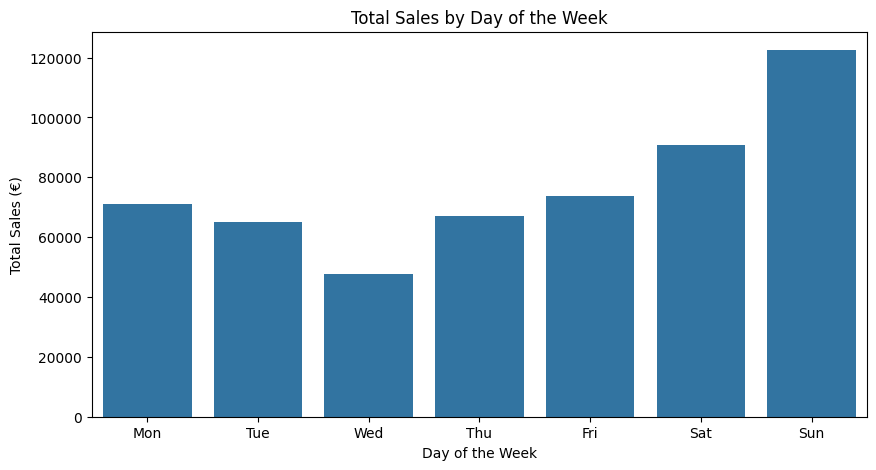

In [30]:
# Plotting sales by day of the week
plt.figure(figsize=(10, 5))
sns.barplot(x=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], y=sales_by_day.values)
plt.title('Total Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales (€)')
plt.show()

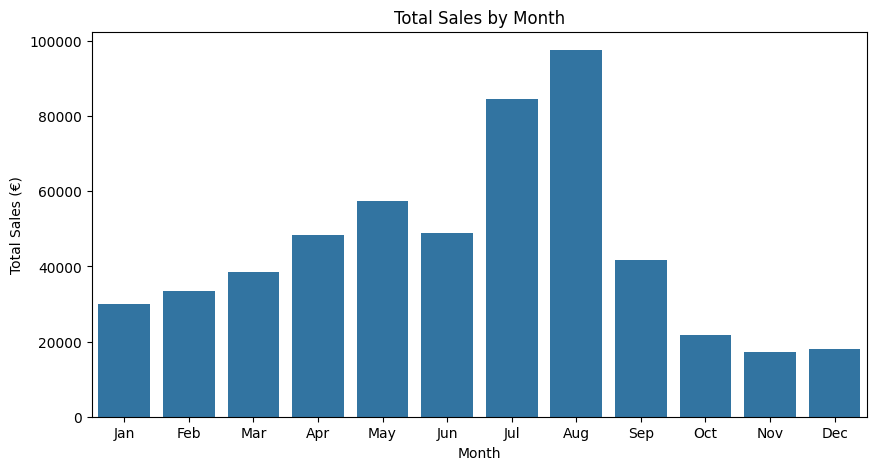

In [31]:
# Plotting sales by month
plt.figure(figsize=(10, 5))
sns.barplot(x=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], y=sales_by_month.values)
plt.title('Total Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales (€)')
plt.show()


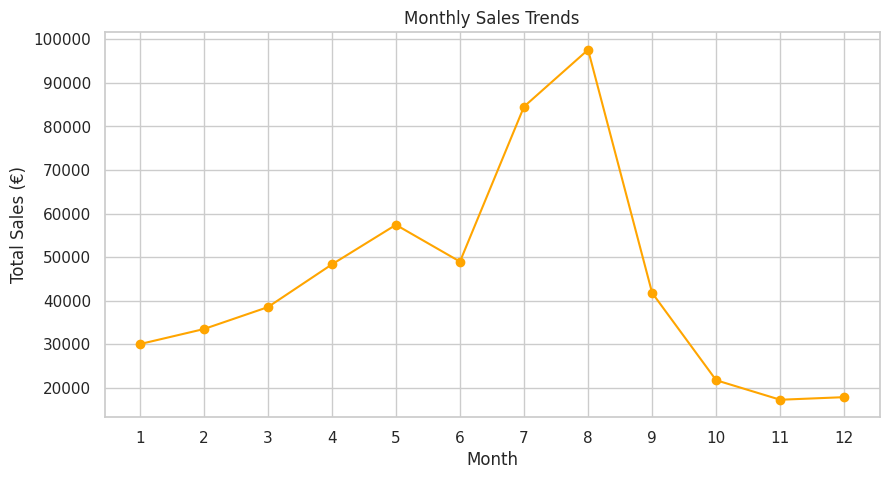

In [ ]:
# Line plot for Monthly Sales Trends
sales_by_month = df.groupby('month')['total_price'].sum()
plt.figure(figsize=(10, 5))
sales_by_month.plot(kind='line', marker='o', color='orange')
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales (€)')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()


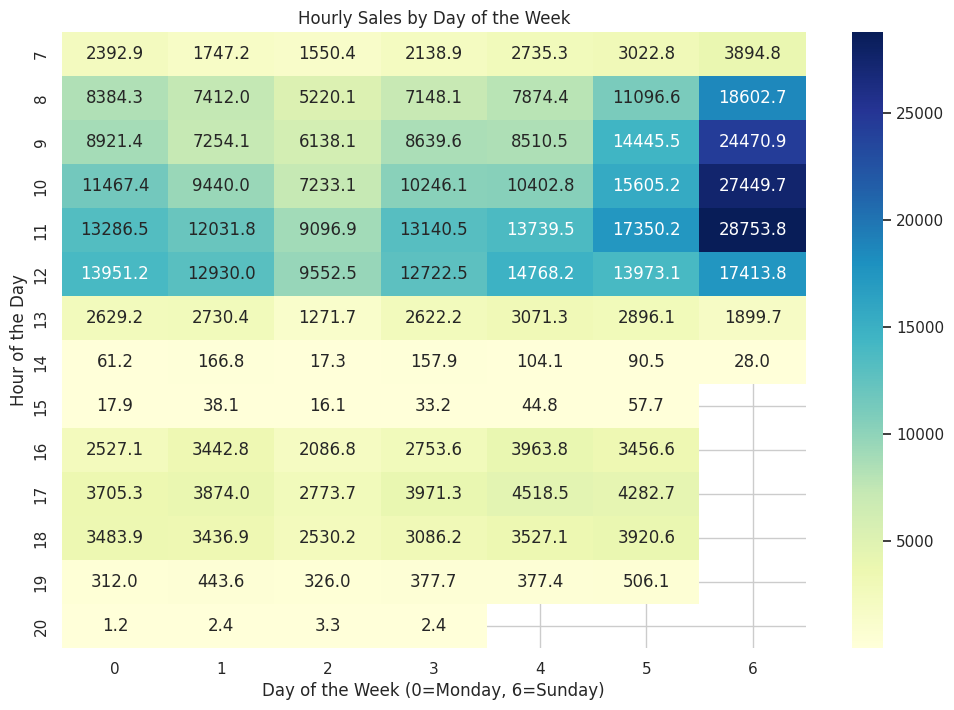

In [ ]:
# Heatmap for Hourly Sales by Day of the Week
heatmap_data = df.pivot_table(values='total_price', index='hour', columns='day_of_week', aggfunc='sum')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt=".1f")
plt.title('Hourly Sales by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Hour of the Day')
plt.show()

#Visualizations

In [32]:
# Sales per Ticket
# Why: To understand the average amount spent per transaction (ticket). It could indicate whether customers are buying in bulk or making small purchases

# Group by ticket_number and calculate total sales per ticket
ticket_sales = df.groupby('ticket_number')['total_price'].sum().reset_index()
avg_sales_per_ticket = ticket_sales['total_price'].mean()

# Show the result
print(f"Average Sales per Ticket: €{avg_sales_per_ticket:.2f}")


Average Sales per Ticket: €3.94


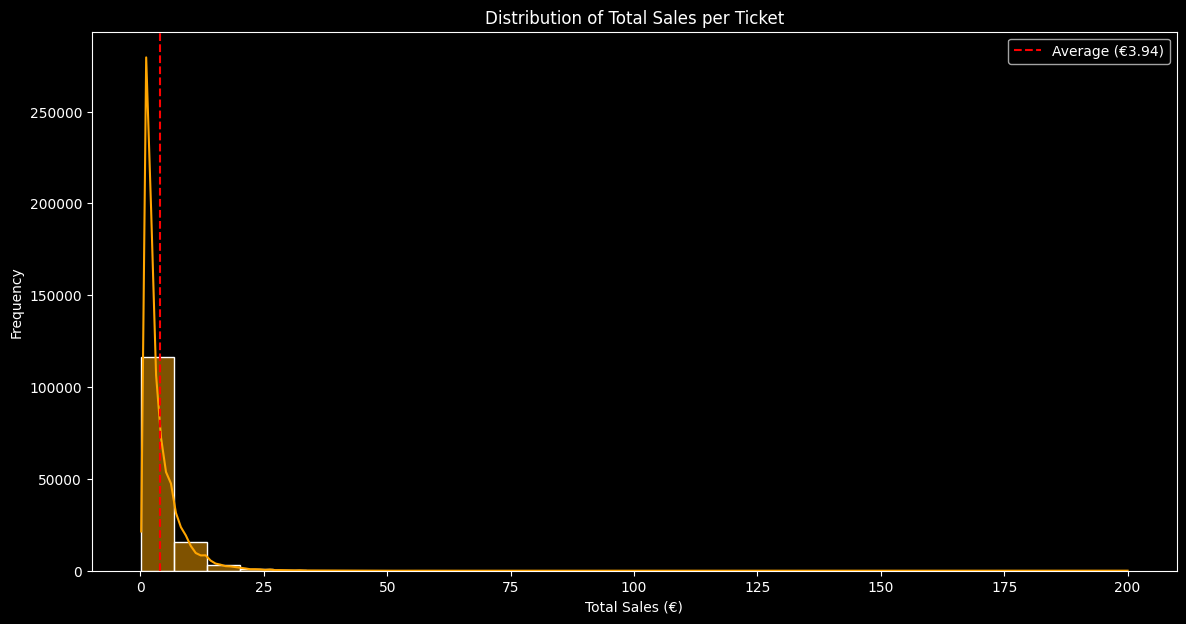

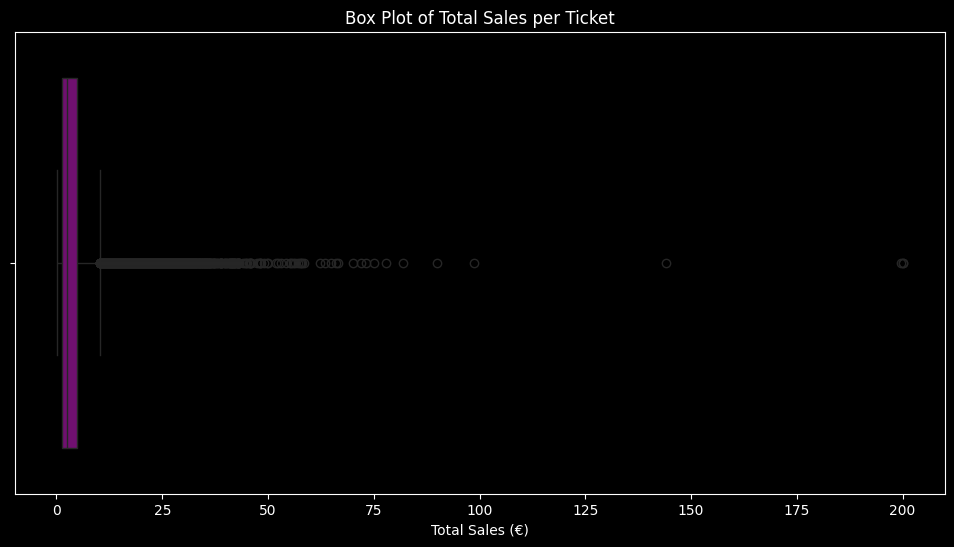

In [33]:
# dark theme for plots
plt.style.use('dark_background')

# Plot a histogram of total sales per ticket
plt.figure(figsize=(14, 7))
sns.histplot(ticket_sales['total_price'], bins=30, kde=True, color='orange')
plt.axvline(avg_sales_per_ticket, color='red', linestyle='--', label=f'Average (€{avg_sales_per_ticket:.2f})')
plt.title('Distribution of Total Sales per Ticket')
plt.xlabel('Total Sales (€)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Box plot for visualizing spread and outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=ticket_sales['total_price'], color='purple')
plt.title('Box Plot of Total Sales per Ticket')
plt.xlabel('Total Sales (€)')
plt.show()


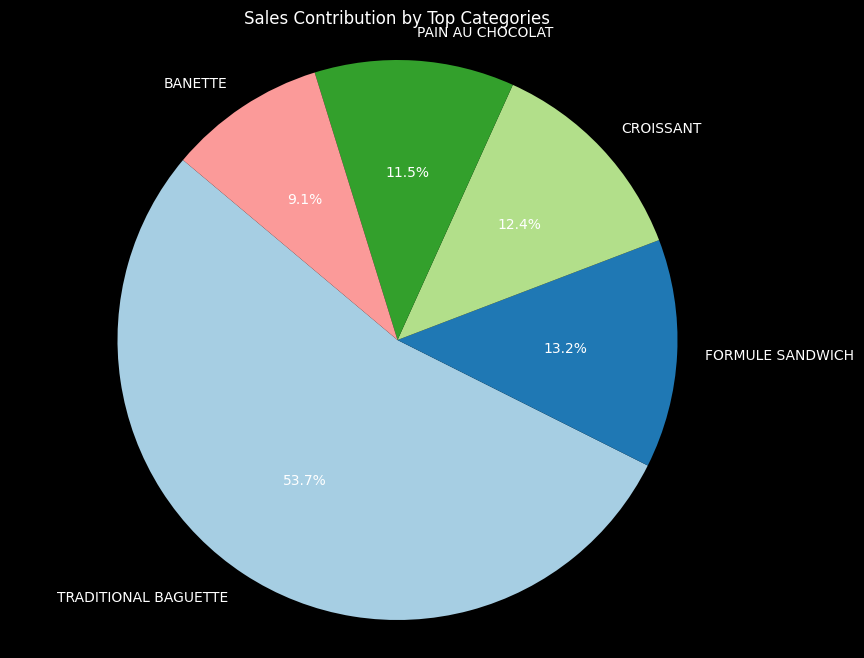

In [34]:
# Group by 'article' and calculate the total sales per product category
category_sales = df.groupby('article')['total_price'].sum().sort_values(ascending=False).head(5)

# Plotting the pie chart for the top 10 categories
plt.figure(figsize=(10, 8))
plt.pie(category_sales, labels=category_sales.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Sales Contribution by Top Categories')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle
plt.show()

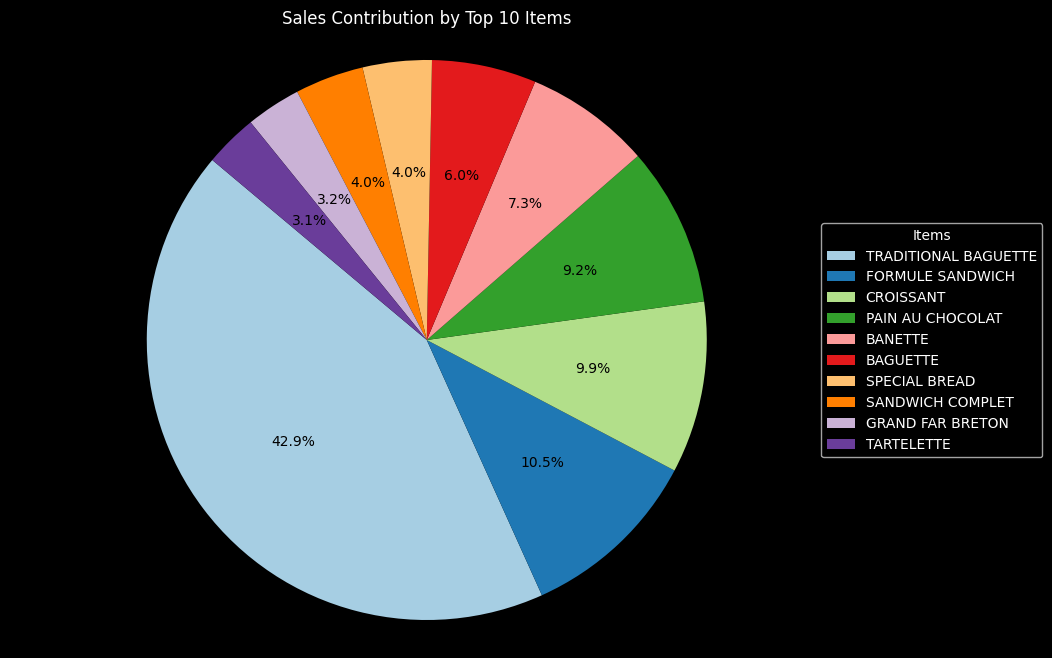

In [35]:
import matplotlib.pyplot as plt

# Group by 'article' and calculate the total sales per product category
category_sales = df.groupby('article')['total_price'].sum().sort_values(ascending=False).head(10)

# Plotting the pie chart for the top 10 categories
plt.figure(figsize=(10, 8))
plt.pie(
    category_sales,
    labels=category_sales.index,
    autopct=lambda p: f'{p:.1f}%',  # Custom formatting for percentages
    startangle=140,
    colors=plt.cm.Paired.colors,
    textprops={'color': 'black'}  # Change text color to black
)
plt.title('Sales Contribution by Top 10 Items')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle

# Add legend to label each section with its corresponding name and value
plt.legend(
    category_sales.index,
    title="Items",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.show()


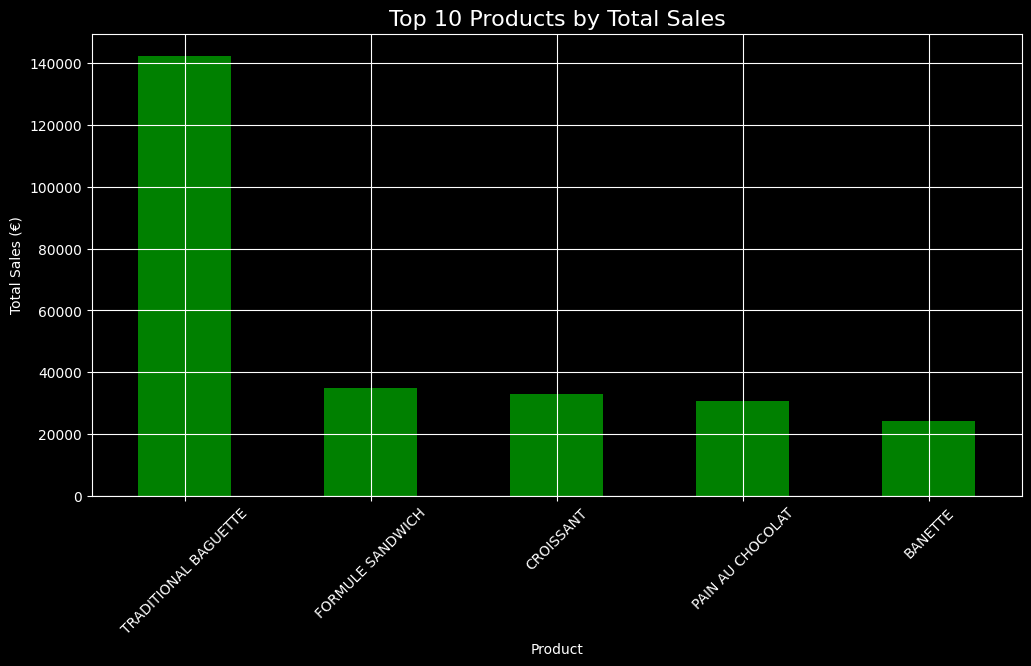

In [36]:
# Product Performance Breakdown (Sales per Product)
# Why: To visualize which products are performing best in terms of sales

# Total sales per product (article)
product_sales = df.groupby('article')['total_price'].sum().sort_values(ascending=False).head(5)

# Plot
product_sales.plot(kind='bar', figsize=(12,6), color='green')
plt.title('Top 10 Products by Total Sales', fontsize=16)
plt.xlabel('Product')
plt.ylabel('Total Sales (€)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


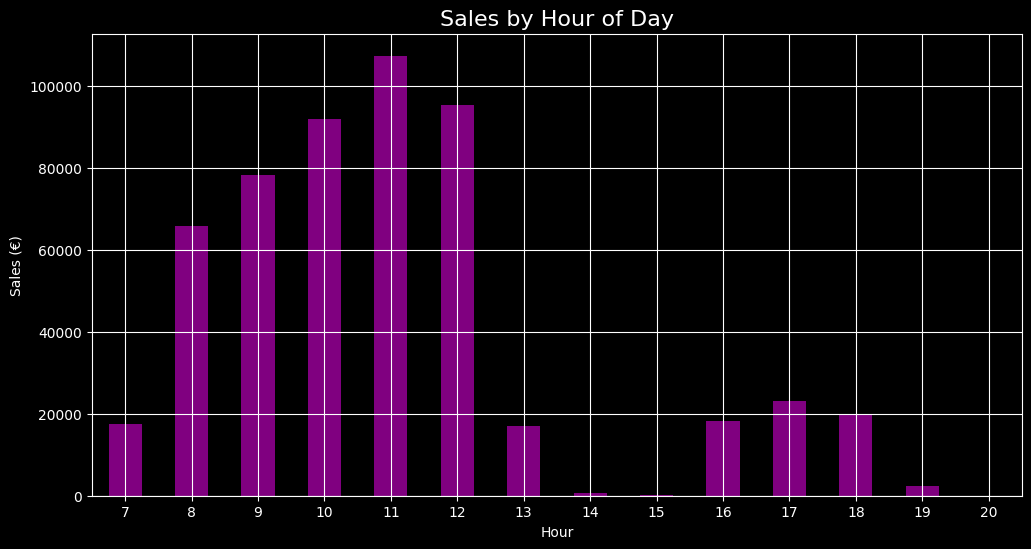

In [37]:
# Sales by Hour of Day
# Why: To understand when sales peak during the day

# Sales by hour of day
hourly_sales = df.groupby('hour')['total_price'].sum()

# Plot
hourly_sales.plot(kind='bar', figsize=(12,6), color='purple')
plt.title('Sales by Hour of Day', fontsize=16)
plt.xlabel('Hour')
plt.ylabel('Sales (€)')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


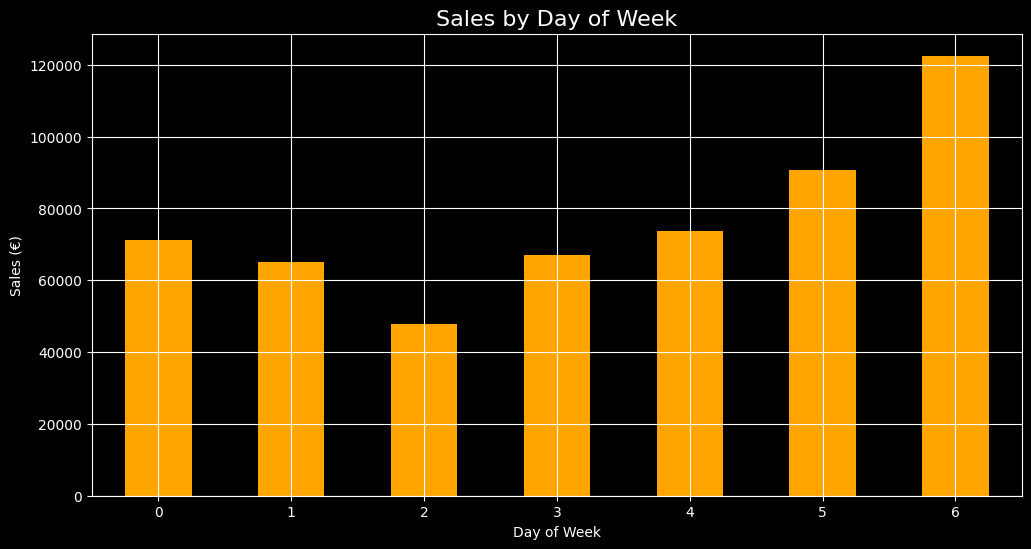

In [38]:
# Sales by Day of Week (Advanced)
# Why: To see if there are any weekly patterns, especially with higher sales on weekends

# Sales by day of week
day_sales = df.groupby('day_of_week')['total_price'].sum()

# Plot
day_sales.plot(kind='bar', figsize=(12,6), color='orange')
plt.title('Sales by Day of Week', fontsize=16)
plt.xlabel('Day of Week')
plt.ylabel('Sales (€)')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


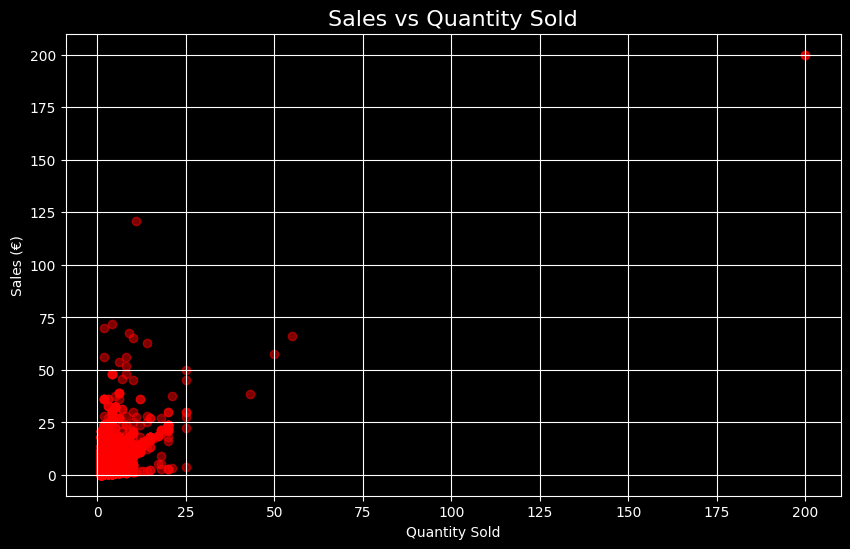

In [39]:
#Sales vs Quantity Sold [scatter plot]
#To understand whether high sales are driven by higher quantities sold or by higher prices (or a combination of both)

plt.figure(figsize=(10,6))
plt.scatter(df['Quantity'], df['total_price'], alpha=0.5, color='red')
plt.title('Sales vs Quantity Sold', fontsize=16)
plt.xlabel('Quantity Sold')
plt.ylabel('Sales (€)')
plt.grid(True)
plt.show()

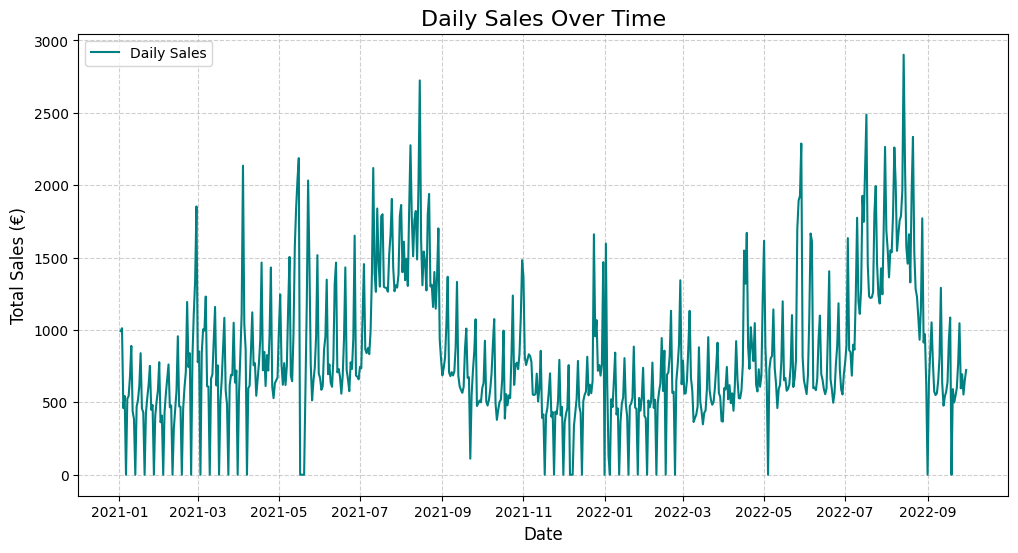

In [8]:
import pandas as pd
import matplotlib.pyplot as plt




# Aggregate sales by date
daily_sales = df.groupby('date')['total_price'].sum().reset_index()

# Ensure all dates are included in the time range
date_range = pd.date_range(start=daily_sales['date'].min(), end=daily_sales['date'].max())
daily_sales = daily_sales.set_index('date').reindex(date_range, fill_value=0).reset_index()
daily_sales.columns = ['date', 'total_price']

# Plotting the time-series data
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['date'], daily_sales['total_price'], label='Daily Sales', color='teal')
plt.title('Daily Sales Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales (€)', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.show()
